In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

In [68]:
##Train
local_zip_train = '/kaggle/input/dogs-vs-cats/train.zip'
zip_ref = zipfile.ZipFile(local_zip_train, 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

##Test
local_zip_test = '/kaggle/input/dogs-vs-cats/test1.zip'
zip_ref = zipfile.ZipFile(local_zip_test, 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

In [69]:

train_dir = '../working/train'
test_dir = '../working/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
print(len(test_files))

12500


In [70]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train' or self.mode == 'val':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.Resize(128),
    transforms.ToTensor()
])

dog_files = [tf for tf in train_files if 'dog' in tf]

train_dataset = CatDogDataset(dog_files, train_dir, transform = data_transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [71]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [92]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,4,(2,2),padding=(1,1))
        self.conv2 = nn.Conv2d(32,64,4,(2,2),padding=(1,1))
        self.conv3 = nn.Conv2d(64,128,4,(2,2),padding=(1,1))
        self.conv4 = nn.Conv2d(128,256,4,(2,2),padding=(1,1))
        self.conv_mu = nn.Conv2d(256,512,4,(2,2),padding=(1,1))
        self.conv_logvar = nn.Conv2d(256,512,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        
        return mu,logvar

In [93]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.t_conv1 = nn.ConvTranspose2d(512,256,4,(2,2),padding=(1,1))
        self.t_conv2 = nn.ConvTranspose2d(256,128,4,(2,2),padding=(1,1))
        self.t_conv3 = nn.ConvTranspose2d(128,64,4,(2,2),padding=(1,1))
        self.t_conv4 = nn.ConvTranspose2d(64,32,4,(2,2),padding=(1,1))
        self.t_conv5 = nn.ConvTranspose2d(32,3,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = torch.sigmoid(self.t_conv5(x))
        
        return x

In [94]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def reparametrize(self,mu,logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.empty_like(std).normal_()
    return eps.mul(std).add_(mu)
  
  def forward(self,x):
    
    mu,logvar = self.encoder(x)
    z = self.reparametrize(mu,logvar)
    x = self.decoder(z)
   
    return (x,mu,logvar)

vae = VAE()
vae = vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_mu): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_logvar): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv5): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [95]:
def vae_loss(recon_x,x,mu,logvar):

  bce_loss = F.binary_cross_entropy(recon_x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return KLD + bce_loss

In [96]:
optimizer = torch.optim.Adam(vae.parameters(),0.001,weight_decay=1e-5)

In [98]:
vae.train()

train_loss_avg = []
num_epochs = 50

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in trainloader:
        
        image_batch = image_batch.to(device)

        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1,num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 906482.139546
Epoch [2 / 50] average reconstruction error: 905631.284527
Epoch [3 / 50] average reconstruction error: 905583.212436
Epoch [4 / 50] average reconstruction error: 904564.303069
Epoch [5 / 50] average reconstruction error: 904041.568734
Epoch [6 / 50] average reconstruction error: 903742.427430
Epoch [7 / 50] average reconstruction error: 903060.045077
Epoch [8 / 50] average reconstruction error: 902897.292519
Epoch [9 / 50] average reconstruction error: 901864.175352
Epoch [10 / 50] average reconstruction error: 902061.923593
Epoch [11 / 50] average reconstruction error: 901456.645780
Epoch [12 / 50] average reconstruction error: 901246.498561
Epoch [13 / 50] average reconstruction error: 901032.141944
Epoch [14 / 50] average reconstruction error: 901361.742967
Epoch [15 / 50] average reconstruction error: 900759.892743
Epoch [16 / 50] average reconstruction error: 901209.551950
Epoch [17 / 50] average reconstructi

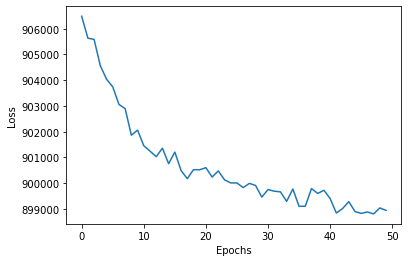

In [99]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

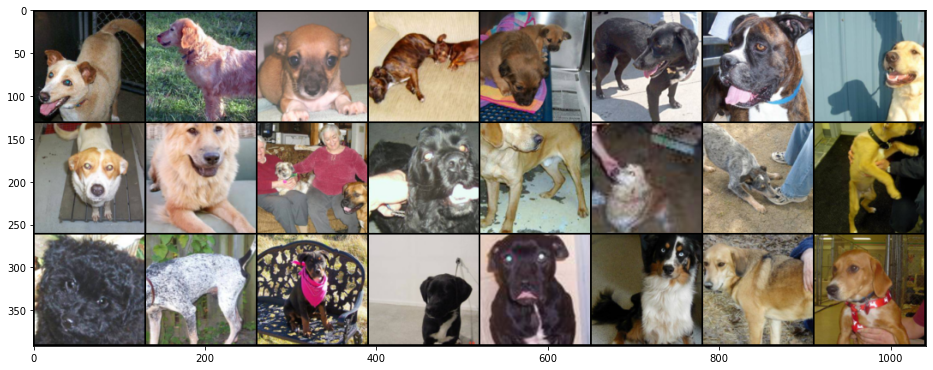

In [100]:
import numpy

samples, labels = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

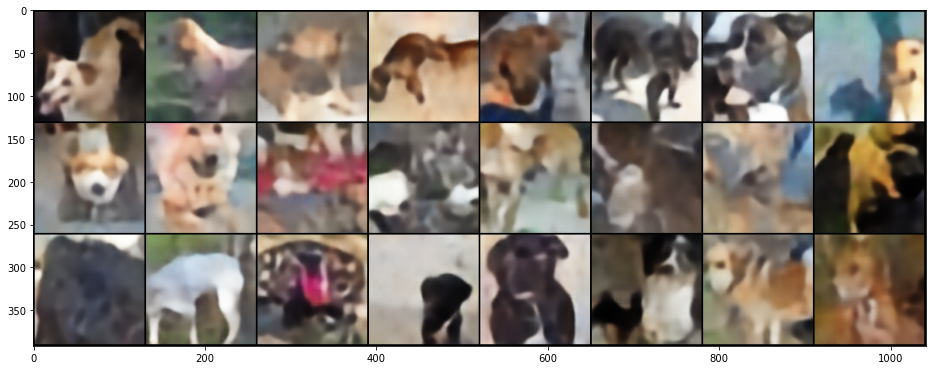

In [101]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

Original images


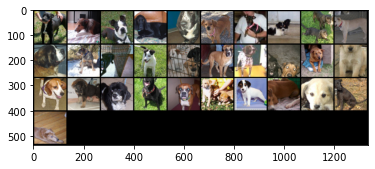

VAE reconstruction:


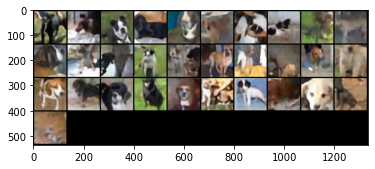

In [102]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(trainloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)